Github Link: https://github.com/SunlightWings/BP-Eye-Foundation-Workshop/tree/main/Classification%20on%20Datos%20dataset


## Objective:
- Quickly run the pipeline for the classification task on the dataset 'Datos'
- Understand the reason behind a great accuracy. Then Handle the poisoned data by not allowing the training data to leak into the test data
- Retrain the model by handling the poisoned data

## Background:

Image classification is the process of labeling the objects in an image from a predefined set of categories. Essentially, our task is to analyze an input image and return a label that categorizes the image. The label is always from a predefined set of possible categories.

<center>

<img src="https://drive.google.com/uc?export=view&id=1yPb6s9-MF1-ZOwEcb6Q77c4qTiKNnFGd" alt="Shows image classification problem" height="400" width="800">

Fig: Image Classification task

</center>

The above picture shows a simple image classification task where there are 2 labels. Depending on the problem, there might be more than 2 labels. In such case, the ideal model will be able to differentiate each of the input images and assign the paricular label to it.

## Dataset Details:

Refer this paper for dataset details:

https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0229226&type=printable

Also don't forget to download the dataset and go through it.


\
* The dataset ‘datos.r’ consists of 180 images each for the four classes:

1. Normal: Healthy ear with no visible abnormalities or signs of infection.

2. Earwax plug: Obstruction in the ear canal due to excessive earwax, potentially causing discomfort or hearing issues.

3. Myringosclerosis: Thickening or scarring of the eardrum, often due to chronic infections or trauma.

4. Chronic otitis media:  Persistent ear infection characterized by inflammation, fluid discharge, and possible hearing loss.

* There are multiple images of the same person in the dataset. (please check this)


## 1. Dataset download:

This dataset called as 'datos' is different from the earlier dataset. So lets prepare it.

In [ ]:
pip install rarfile

In [ ]:
import os
import zipfile
import rarfile
import requests
from pathlib import Path
import tqdm

In [ ]:
def download_and_extract_rar(url, output_path):
    """Download and extract a .rar file from a URL."""
    filename = url.split("/")[-1]
    response = requests.get(url, stream=True)
    if response.status_code == 200:  # Server successfully answered the HTTP request
        print("Downloading dataset...")
        with open(filename, "wb") as f:
            for chunk in tqdm.tqdm(response.iter_content(chunk_size=1024), desc="Downloading", unit="KB"):
                if chunk:
                    f.write(chunk)
        print("Download complete.")

        # Extracting the .rar file
        print("Extracting files...")
        with rarfile.RarFile(filename, 'r') as rar_ref:
            rar_ref.extractall(output_path)
        print(f"Dataset extracted to {output_path}.")

        # Remove the downloaded .rar file
        os.remove(filename)
    else:
        print(f"Failed to download dataset: {response.status_code}")

In [ ]:
# Set dataset URL and output path
dataset_url = "https://figshare.com/ndownloader/files/21793293"
output_path = "/content/datos_dataset"

In [ ]:
os.makedirs(output_path, exist_ok=True)

In [ ]:
# Download and extract the dataset
download_and_extract_rar(dataset_url, output_path)

Downloading: 10728KB [00:01, 6784.22KB/s] 


Download complete.
Extracting files...
Dataset extracted to /content/datos_dataset.


On the left side bar, click on the folder icon to check if the dataset has been downloaded.

In [ ]:
print("Files/Directory inside the output_dir:")
print(os.listdir(output_path))

Files/Directory inside the output_dir:
['Datos']


## 2. EDA

In [ ]:
pip install pillow

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os

In [ ]:
# Function to display the first N images from each class
def display_images(categories, samples_per_class):
    plt.figure(figsize=(16, 16))

    for i, (class_name, folder_path) in enumerate(categories.items()):  # Parse class names and paths
        # Get all image files in the directory
        image_files = sorted([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

        # Select the first few images
        selected_images = image_files[:samples_per_class]

        for j, image_name in enumerate(selected_images):
            image_path = os.path.join(folder_path, image_name)

            # Load and display the image
            plt.subplot(len(categories), samples_per_class, i * samples_per_class + j + 1)
            img = Image.open(image_path)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"{class_name}", fontsize=12)

    plt.tight_layout()
    plt.show()

In [ ]:
# Example Usage
# Define the categories and their corresponding folder paths
dataset_root = "./datos_dataset/Datos"  # Root directory of the dataset
categories = {
    "Chronic otitis media": os.path.join(dataset_root, "Testing", "Chronic otitis media"),
    "Earwax plug": os.path.join(dataset_root, "Testing", "Earwax plug"),
    "Myringosclerosis": os.path.join(dataset_root, "Testing", "Myringosclerosis"),
    "Normal": os.path.join(dataset_root, "Testing", "Normal")
}

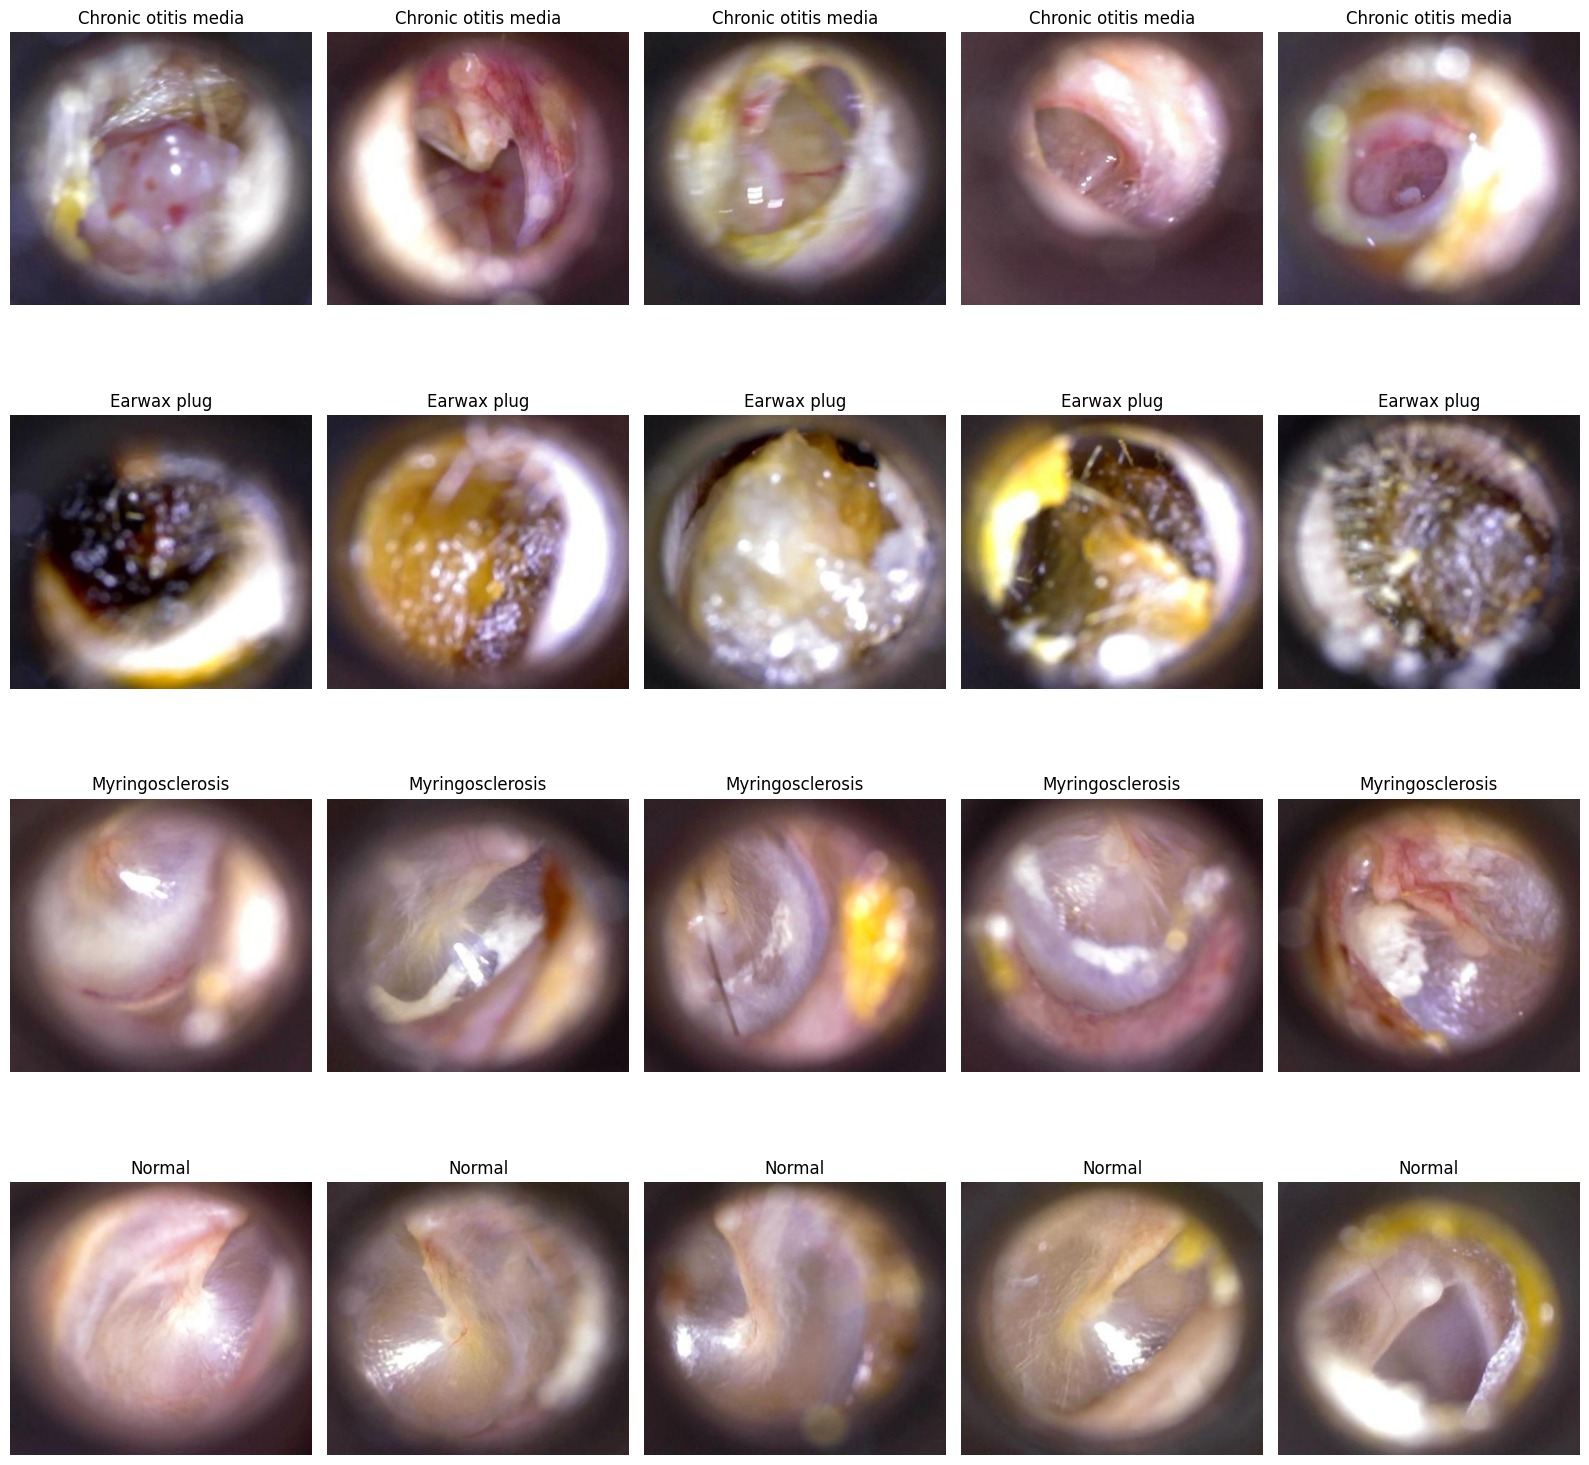

In [ ]:
# Display the first 5 images from each class
display_images(categories, samples_per_class=5)

## 3. Preprocessing

In [ ]:
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

In [ ]:
class EardrumDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.data = []  # List to store (image_path, class_index) pairs
        self.transform = transform

        # Get the class names from the directory structure
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

        # Collect all image paths and their corresponding class indices
        for class_name in self.classes:
            class_index = self.class_to_idx[class_name]
            class_path = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                if os.path.isfile(img_path):
                    self.data.append((img_path, class_index))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")  # Ensure the image is in RGB format

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Paths to the dataset directories
train_val_dir = "datos_dataset/Datos/Training-validation"
test_dir = "datos_dataset/Datos/Testing"

In [ ]:
# Create the training-validation dataset
train_val_dataset = EardrumDataset(train_val_dir, transform=transform)

In [ ]:
# Define the train-validation split ratio
train_ratio = 0.8  # 80% for training
val_ratio = 0.2    # 20% for validation

In [ ]:
total_size = len(train_val_dataset)
train_size = int(train_ratio * total_size)
val_size = total_size - train_size

In [ ]:
# Split the dataset into training and validation sets
train_set, val_set = random_split(train_val_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

In [ ]:
# Create the test dataset
test_dataset = EardrumDataset(test_dir, transform=transform)

In [ ]:
batch_size = 8

In [ ]:
# Create DataLoaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Print dataset sizes
print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 576
Validation set size: 144
Test set size: 160


In [ ]:
# Example: Iterate through the training DataLoader
for images, labels in train_loader:
    print(f"Batch size: {images.size(0)}")
    print(f"Image shape: {images.shape}")
    print(f"Labels: {labels}")
    break

Batch size: 8
Image shape: torch.Size([8, 3, 224, 224])
Labels: tensor([2, 2, 3, 3, 3, 2, 3, 3])


## 4. Model building

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torchvision

In [ ]:
pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 20.7 MB/s eta 0:00:00


In [ ]:
from torchmetrics import Accuracy

In [ ]:
import torchvision
kwargs={}
resnet_model = torchvision.models.resnet50(weights=None, num_classes=7, progress=True, **kwargs)

In [ ]:
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 5. Training

In [ ]:
import torch.optim as optim
from tqdm import tqdm

In [ ]:
from google.colab import drive

# Try unmounting first (in case it was already mounted)
try:
  drive.flush_and_unmount()
  print('Drive unmounted')
except ValueError:
  pass  # Ignore errors if it wasn't mounted

# Clear the directory (be careful, this will delete all files in it)
!rm -rf /content/drive

# Now try mounting again
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Drive unmounted
Mounted at /content/drive


In [ ]:
import os

def train_model(model, train_loader, val_loader, num_epochs, device, save_path):
    # Mount Google Drive (if necessary)
    from google.colab import drive
    drive.mount('/content/drive')

    # Criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.to(device)

    # Initialize logs
    logs = {
        "train_loss": [],
        "val_loss": [],
        "train_accuracy": [],
        "val_accuracy": []
    }
    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_accuracy = correct / total * 100
        logs["train_loss"].append(train_loss)
        logs["train_accuracy"].append(train_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_accuracy = val_correct / val_total * 100
        logs["val_loss"].append(val_loss)
        logs["val_accuracy"].append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), os.path.join(save_path, "best_model.pth"))
            print(f"Best model saved with Validation Accuracy: {val_accuracy:.2f}%")

        # Save model every 10 epochs
        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), os.path.join(save_path, f"model_epoch_{epoch+1}.pth"))
            print(f"Model saved at epoch {epoch+1}")

    # Save logs for plotting
    torch.save(logs, os.path.join(save_path, "training_logs.pth"))
    print("Training completed and logs saved.")


In [ ]:
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


The file is saved at:

https://drive.google.com/drive/folders/1jLI1wwxQqTvTZT_7sXebVGRcG-eHErcO?fbclid=IwAR1nOLKOcUspFEsgLekYPDDrkYrCksOX6rK1hhLPxGfVXFmom5uFLhK728g

In [ ]:
save_path = '/content/drive/MyDrive/naamii/workshop/datos'

In [ ]:
train_model(resnet_model, train_loader, val_loader, num_epochs, device, save_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Epoch 1/50 - Training: 100%|██████████| 72/72 [00:09<00:00,  7.23it/s]


Epoch 1/50, Train Loss: 1.4072, Train Accuracy: 46.70%


Epoch 1/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 19.89it/s]


Epoch 1/50, Val Loss: 1.7897, Val Accuracy: 32.64%
Best model saved with Validation Accuracy: 32.64%


Epoch 2/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.24it/s]


Epoch 2/50, Train Loss: 0.9169, Train Accuracy: 63.54%


Epoch 2/50 - Validation: 100%|██████████| 18/18 [00:01<00:00, 16.81it/s]


Epoch 2/50, Val Loss: 0.7559, Val Accuracy: 70.83%
Best model saved with Validation Accuracy: 70.83%


Epoch 3/50 - Training: 100%|██████████| 72/72 [00:09<00:00,  7.38it/s]


Epoch 3/50, Train Loss: 0.7835, Train Accuracy: 69.97%


Epoch 3/50 - Validation: 100%|██████████| 18/18 [00:01<00:00, 11.63it/s]


Epoch 3/50, Val Loss: 2.6822, Val Accuracy: 44.44%


Epoch 4/50 - Training: 100%|██████████| 72/72 [00:09<00:00,  7.81it/s]


Epoch 4/50, Train Loss: 0.8103, Train Accuracy: 66.84%


Epoch 4/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 19.96it/s]


Epoch 4/50, Val Loss: 0.8189, Val Accuracy: 73.61%
Best model saved with Validation Accuracy: 73.61%


Epoch 5/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.25it/s]


Epoch 5/50, Train Loss: 0.5389, Train Accuracy: 80.21%


Epoch 5/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 18.75it/s]


Epoch 5/50, Val Loss: 0.5588, Val Accuracy: 77.78%
Best model saved with Validation Accuracy: 77.78%


Epoch 6/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.17it/s]


Epoch 6/50, Train Loss: 0.5580, Train Accuracy: 76.56%


Epoch 6/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 18.43it/s]


Epoch 6/50, Val Loss: 2.6125, Val Accuracy: 47.92%


Epoch 7/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.36it/s]


Epoch 7/50, Train Loss: 0.5413, Train Accuracy: 78.30%


Epoch 7/50 - Validation: 100%|██████████| 18/18 [00:01<00:00, 16.24it/s]


Epoch 7/50, Val Loss: 0.9362, Val Accuracy: 72.22%


Epoch 8/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.09it/s]


Epoch 8/50, Train Loss: 0.4331, Train Accuracy: 85.94%


Epoch 8/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 19.10it/s]


Epoch 8/50, Val Loss: 1.4061, Val Accuracy: 64.58%


Epoch 9/50 - Training: 100%|██████████| 72/72 [00:09<00:00,  7.94it/s]


Epoch 9/50, Train Loss: 0.4913, Train Accuracy: 81.94%


Epoch 9/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 19.26it/s]


Epoch 9/50, Val Loss: 0.8855, Val Accuracy: 70.14%


Epoch 10/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.13it/s]


Epoch 10/50, Train Loss: 0.4060, Train Accuracy: 85.76%


Epoch 10/50 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.47it/s]


Epoch 10/50, Val Loss: 0.7291, Val Accuracy: 78.47%
Best model saved with Validation Accuracy: 78.47%
Model saved at epoch 10


Epoch 11/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.41it/s]


Epoch 11/50, Train Loss: 0.3277, Train Accuracy: 89.58%


Epoch 11/50 - Validation: 100%|██████████| 18/18 [00:01<00:00, 17.83it/s]


Epoch 11/50, Val Loss: 0.3561, Val Accuracy: 90.97%
Best model saved with Validation Accuracy: 90.97%


Epoch 12/50 - Training: 100%|██████████| 72/72 [00:09<00:00,  7.87it/s]


Epoch 12/50, Train Loss: 0.3437, Train Accuracy: 88.02%


Epoch 12/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 18.14it/s]


Epoch 12/50, Val Loss: 0.4804, Val Accuracy: 84.03%


Epoch 13/50 - Training: 100%|██████████| 72/72 [00:09<00:00,  7.74it/s]


Epoch 13/50, Train Loss: 0.3396, Train Accuracy: 86.98%


Epoch 13/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 19.21it/s]


Epoch 13/50, Val Loss: 0.1098, Val Accuracy: 95.83%
Best model saved with Validation Accuracy: 95.83%


Epoch 14/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.39it/s]


Epoch 14/50, Train Loss: 0.1918, Train Accuracy: 93.40%


Epoch 14/50 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.14it/s]


Epoch 14/50, Val Loss: 0.1691, Val Accuracy: 92.36%


Epoch 15/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.19it/s]


Epoch 15/50, Train Loss: 0.3149, Train Accuracy: 88.89%


Epoch 15/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 18.42it/s]


Epoch 15/50, Val Loss: 0.2781, Val Accuracy: 88.89%


Epoch 16/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.06it/s]


Epoch 16/50, Train Loss: 0.2171, Train Accuracy: 92.36%


Epoch 16/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 19.09it/s]


Epoch 16/50, Val Loss: 0.3913, Val Accuracy: 86.11%


Epoch 17/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.02it/s]


Epoch 17/50, Train Loss: 0.2475, Train Accuracy: 90.45%


Epoch 17/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 19.24it/s]


Epoch 17/50, Val Loss: 0.2344, Val Accuracy: 91.67%


Epoch 18/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.43it/s]


Epoch 18/50, Train Loss: 0.2035, Train Accuracy: 92.01%


Epoch 18/50 - Validation: 100%|██████████| 18/18 [00:01<00:00, 16.26it/s]


Epoch 18/50, Val Loss: 0.3507, Val Accuracy: 86.11%


Epoch 19/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.01it/s]


Epoch 19/50, Train Loss: 0.1967, Train Accuracy: 92.88%


Epoch 19/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 18.30it/s]


Epoch 19/50, Val Loss: 0.1340, Val Accuracy: 95.83%


Epoch 20/50 - Training: 100%|██████████| 72/72 [00:09<00:00,  7.99it/s]


Epoch 20/50, Train Loss: 0.1812, Train Accuracy: 93.92%


Epoch 20/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 18.51it/s]


Epoch 20/50, Val Loss: 0.0793, Val Accuracy: 98.61%
Best model saved with Validation Accuracy: 98.61%
Model saved at epoch 20


Epoch 21/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.11it/s]


Epoch 21/50, Train Loss: 0.1972, Train Accuracy: 94.62%


Epoch 21/50 - Validation: 100%|██████████| 18/18 [00:01<00:00, 12.04it/s]


Epoch 21/50, Val Loss: 0.5731, Val Accuracy: 87.50%


Epoch 22/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.19it/s]


Epoch 22/50, Train Loss: 0.1781, Train Accuracy: 93.75%


Epoch 22/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 18.95it/s]


Epoch 22/50, Val Loss: 0.1652, Val Accuracy: 92.36%


Epoch 23/50 - Training: 100%|██████████| 72/72 [00:09<00:00,  7.96it/s]


Epoch 23/50, Train Loss: 0.1838, Train Accuracy: 93.40%


Epoch 23/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 18.48it/s]


Epoch 23/50, Val Loss: 0.2645, Val Accuracy: 92.36%


Epoch 24/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.03it/s]


Epoch 24/50, Train Loss: 0.1873, Train Accuracy: 92.36%


Epoch 24/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 18.85it/s]


Epoch 24/50, Val Loss: 0.2187, Val Accuracy: 93.75%


Epoch 25/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.31it/s]


Epoch 25/50, Train Loss: 0.1234, Train Accuracy: 96.18%


Epoch 25/50 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.83it/s]


Epoch 25/50, Val Loss: 0.0840, Val Accuracy: 97.22%


Epoch 26/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.13it/s]


Epoch 26/50, Train Loss: 0.2210, Train Accuracy: 93.06%


Epoch 26/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 18.15it/s]


Epoch 26/50, Val Loss: 0.7761, Val Accuracy: 73.61%


Epoch 27/50 - Training: 100%|██████████| 72/72 [00:09<00:00,  7.96it/s]


Epoch 27/50, Train Loss: 0.1761, Train Accuracy: 93.58%


Epoch 27/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 18.04it/s]


Epoch 27/50, Val Loss: 0.1709, Val Accuracy: 94.44%


Epoch 28/50 - Training: 100%|██████████| 72/72 [00:09<00:00,  7.70it/s]


Epoch 28/50, Train Loss: 0.1455, Train Accuracy: 95.66%


Epoch 28/50 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.04it/s]


Epoch 28/50, Val Loss: 0.2850, Val Accuracy: 89.58%


Epoch 29/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.26it/s]


Epoch 29/50, Train Loss: 0.0975, Train Accuracy: 96.18%


Epoch 29/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 18.48it/s]


Epoch 29/50, Val Loss: 0.3618, Val Accuracy: 85.42%


Epoch 30/50 - Training: 100%|██████████| 72/72 [00:09<00:00,  7.98it/s]


Epoch 30/50, Train Loss: 0.2444, Train Accuracy: 91.15%


Epoch 30/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 19.75it/s]


Epoch 30/50, Val Loss: 0.2499, Val Accuracy: 90.97%
Model saved at epoch 30


Epoch 31/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.12it/s]


Epoch 31/50, Train Loss: 0.0953, Train Accuracy: 97.40%


Epoch 31/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 18.34it/s]


Epoch 31/50, Val Loss: 0.2308, Val Accuracy: 90.28%


Epoch 32/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.41it/s]


Epoch 32/50, Train Loss: 0.1414, Train Accuracy: 94.79%


Epoch 32/50 - Validation: 100%|██████████| 18/18 [00:01<00:00, 17.79it/s]


Epoch 32/50, Val Loss: 0.2615, Val Accuracy: 90.28%


Epoch 33/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.13it/s]


Epoch 33/50, Train Loss: 0.1347, Train Accuracy: 95.83%


Epoch 33/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 19.30it/s]


Epoch 33/50, Val Loss: 0.3151, Val Accuracy: 88.19%


Epoch 34/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.12it/s]


Epoch 34/50, Train Loss: 0.1390, Train Accuracy: 94.79%


Epoch 34/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 19.04it/s]


Epoch 34/50, Val Loss: 0.1508, Val Accuracy: 96.53%


Epoch 35/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.31it/s]


Epoch 35/50, Train Loss: 0.0715, Train Accuracy: 97.40%


Epoch 35/50 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.07it/s]


Epoch 35/50, Val Loss: 0.1937, Val Accuracy: 94.44%


Epoch 36/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.34it/s]


Epoch 36/50, Train Loss: 0.1134, Train Accuracy: 96.70%


Epoch 36/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 18.70it/s]


Epoch 36/50, Val Loss: 0.1012, Val Accuracy: 97.22%


Epoch 37/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.06it/s]


Epoch 37/50, Train Loss: 0.1198, Train Accuracy: 95.83%


Epoch 37/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 19.35it/s]


Epoch 37/50, Val Loss: 0.1274, Val Accuracy: 95.14%


Epoch 38/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.13it/s]


Epoch 38/50, Train Loss: 0.0919, Train Accuracy: 96.53%


Epoch 38/50 - Validation: 100%|██████████| 18/18 [00:01<00:00, 17.87it/s]


Epoch 38/50, Val Loss: 1.7971, Val Accuracy: 72.22%


Epoch 39/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.47it/s]


Epoch 39/50, Train Loss: 0.1132, Train Accuracy: 96.53%


Epoch 39/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 18.16it/s]


Epoch 39/50, Val Loss: 0.3124, Val Accuracy: 90.97%


Epoch 40/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.12it/s]


Epoch 40/50, Train Loss: 0.0515, Train Accuracy: 98.78%


Epoch 40/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 19.39it/s]


Epoch 40/50, Val Loss: 0.0888, Val Accuracy: 96.53%
Model saved at epoch 40


Epoch 41/50 - Training: 100%|██████████| 72/72 [00:09<00:00,  7.85it/s]


Epoch 41/50, Train Loss: 0.0794, Train Accuracy: 96.88%


Epoch 41/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 19.27it/s]


Epoch 41/50, Val Loss: 0.3060, Val Accuracy: 91.67%


Epoch 42/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.33it/s]


Epoch 42/50, Train Loss: 0.0469, Train Accuracy: 98.26%


Epoch 42/50 - Validation: 100%|██████████| 18/18 [00:01<00:00, 15.35it/s]


Epoch 42/50, Val Loss: 0.1205, Val Accuracy: 94.44%


Epoch 43/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.28it/s]


Epoch 43/50, Train Loss: 0.1323, Train Accuracy: 96.01%


Epoch 43/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 20.11it/s]


Epoch 43/50, Val Loss: 0.0936, Val Accuracy: 97.22%


Epoch 44/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.13it/s]


Epoch 44/50, Train Loss: 0.1007, Train Accuracy: 97.40%


Epoch 44/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 19.09it/s]


Epoch 44/50, Val Loss: 0.0833, Val Accuracy: 95.14%


Epoch 45/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.10it/s]


Epoch 45/50, Train Loss: 0.1540, Train Accuracy: 95.49%


Epoch 45/50 - Validation: 100%|██████████| 18/18 [00:01<00:00, 16.20it/s]


Epoch 45/50, Val Loss: 0.2040, Val Accuracy: 93.06%


Epoch 46/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.42it/s]


Epoch 46/50, Train Loss: 0.0464, Train Accuracy: 98.44%


Epoch 46/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 18.50it/s]


Epoch 46/50, Val Loss: 0.1383, Val Accuracy: 97.22%


Epoch 47/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.07it/s]


Epoch 47/50, Train Loss: 0.0932, Train Accuracy: 97.05%


Epoch 47/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 18.55it/s]


Epoch 47/50, Val Loss: 0.1424, Val Accuracy: 96.53%


Epoch 48/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.02it/s]


Epoch 48/50, Train Loss: 0.0871, Train Accuracy: 97.22%


Epoch 48/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 18.88it/s]


Epoch 48/50, Val Loss: 0.1113, Val Accuracy: 97.22%


Epoch 49/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.41it/s]


Epoch 49/50, Train Loss: 0.0355, Train Accuracy: 98.78%


Epoch 49/50 - Validation: 100%|██████████| 18/18 [00:01<00:00, 14.70it/s]


Epoch 49/50, Val Loss: 0.0977, Val Accuracy: 97.92%


Epoch 50/50 - Training: 100%|██████████| 72/72 [00:08<00:00,  8.25it/s]


Epoch 50/50, Train Loss: 0.0668, Train Accuracy: 97.74%


Epoch 50/50 - Validation: 100%|██████████| 18/18 [00:00<00:00, 18.79it/s]


Epoch 50/50, Val Loss: 0.1473, Val Accuracy: 96.53%
Model saved at epoch 50
Training completed and logs saved.


In [ ]:
import matplotlib.pyplot as plt

def plot_training_logs(logs_path):
    # Load logs
    logs = torch.load(logs_path)

    train_loss = logs["train_loss"]
    val_loss = logs["val_loss"]
    train_accuracy = logs["train_accuracy"]
    val_accuracy = logs["val_accuracy"]

    # Plot Loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label="Training Loss", color="blue")
    plt.plot(val_loss, label="Validation Loss", color="orange")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracy, label="Training Accuracy", color="green")
    plt.plot(val_accuracy, label="Validation Accuracy", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

<ipython-input-35-32f49ee18464>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  logs = torch.load(logs_path)


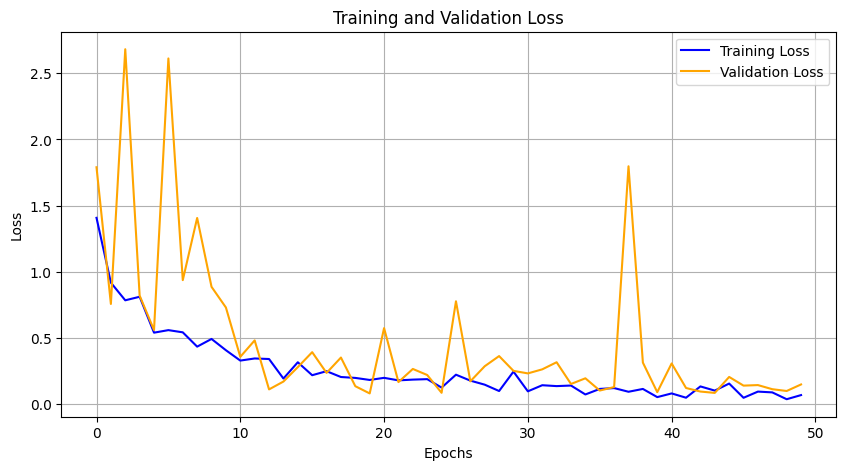

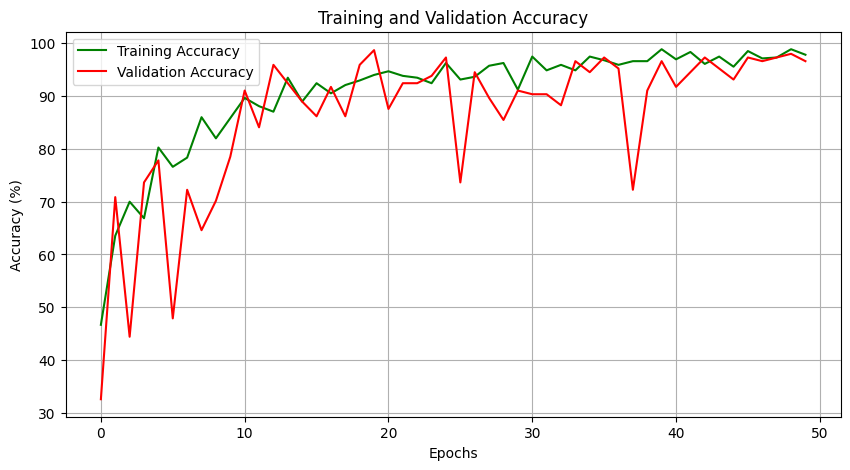

In [ ]:
# Example usage
logs_path = "/content/drive/MyDrive/naamii/workshop/datos/training_logs.pth"  # Update the path to match your logs
plot_training_logs(logs_path)

The training logs is saved at the above path.

## 6. Evaluation

In [ ]:
def test_model(model, test_loader, device, model_path):
    """
    Test the model on the test set and compute accuracy and loss.

    Args:
    - model: The trained model.
    - test_loader: DataLoader for the test set.
    - device: Device to run the testing (e.g., 'cuda' or 'cpu').
    - model_path: Path to the saved best model.

    Returns:
    - test_loss: Average test loss.
    - test_accuracy: Test accuracy in percentage.
    """
    # Load the best model
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    criterion = nn.CrossEntropyLoss()

    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Accumulate loss
            test_loss += loss.item() * images.size(0)

            # Compute accuracy
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_loss /= total
    test_accuracy = correct / total * 100

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    return test_loss, test_accuracy

* **Find the trained model at**:

https://drive.google.com/drive/folders/1jLI1wwxQqTvTZT_7sXebVGRcG-eHErcO?fbclid=IwAR1nOLKOcUspFEsgLekYPDDrkYrCksOX6rK1hhLPxGfVXFmom5uFLhK728g



In [ ]:
model_path = "/content/drive/MyDrive/naamii/workshop/datos/model_epoch_50.pth"  # Path to the saved best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_loss, test_accuracy = test_model(resnet_model, test_loader, device, model_path)

<ipython-input-37-2de0d7330dd1>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
Testing: 100%|██████████| 20/20 [00:02<00:00,

Test Loss: 0.7709
Test Accuracy: 85.62%


Detailed metrics:

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [ ]:
def evaluate_model(model, test_loader, device, model_path, class_names):
    # Load the best model
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    criterion = nn.CrossEntropyLoss()

    # Initialize accumulators and metrics
    test_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Accumulate loss
            test_loss += loss.item() * images.size(0)

            # Store predictions and true labels
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to NumPy arrays for sklearn metrics
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate test loss
    test_loss /= len(test_loader.dataset)

    # Classification report
    class_report = classification_report(all_labels, all_preds, target_names=class_names, digits=4, output_dict=True)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Class-wise accuracy
    class_accuracy = {class_names[i]: conf_matrix[i, i] / conf_matrix[i].sum() for i in range(len(class_names))}

    # Print metrics
    print(f"Test Loss: {test_loss:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
    print("\nConfusion Matrix:")
    print(conf_matrix)

    # Prepare metrics dictionary
    metrics = {
        "test_loss": test_loss,
        "class_report": class_report,
        "confusion_matrix": conf_matrix,
        "class_accuracy": class_accuracy,
    }

    return metrics

same path specified below

In [ ]:
model_path = "/content/drive/MyDrive/naamii/workshop/datos/model_epoch_50.pth"  # Path to the saved best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
class_names = ["Chronic Otitis Media", "Earwax Plug", "Myringosclerosis", "Normal"]

metrics = evaluate_model(resnet_model, test_loader, device, model_path, class_names)

<ipython-input-40-2176a71d715c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
Testing: 100%|██████████| 20/20 [00:01<00:00, 

Test Loss: 0.7709

Classification Report:
                      precision    recall  f1-score   support

Chronic Otitis Media     0.9167    0.8250    0.8684        40
         Earwax Plug     0.9444    0.8500    0.8947        40
    Myringosclerosis     0.6731    0.8750    0.7609        40
              Normal     0.9722    0.8750    0.9211        40

            accuracy                         0.8562       160
           macro avg     0.8766    0.8562    0.8613       160
        weighted avg     0.8766    0.8562    0.8613       160


Confusion Matrix:
[[33  1  6  0]
 [ 0 34  6  0]
 [ 3  1 35  1]
 [ 0  0  5 35]]


In [ ]:
print("\nClass-wise Accuracy:")
for class_name, accuracy in metrics["class_accuracy"].items():
    print(f"{class_name}: {accuracy:.2%}")



Class-wise Accuracy:
Chronic Otitis Media: 82.50%
Earwax Plug: 85.00%
Myringosclerosis: 87.50%
Normal: 87.50%


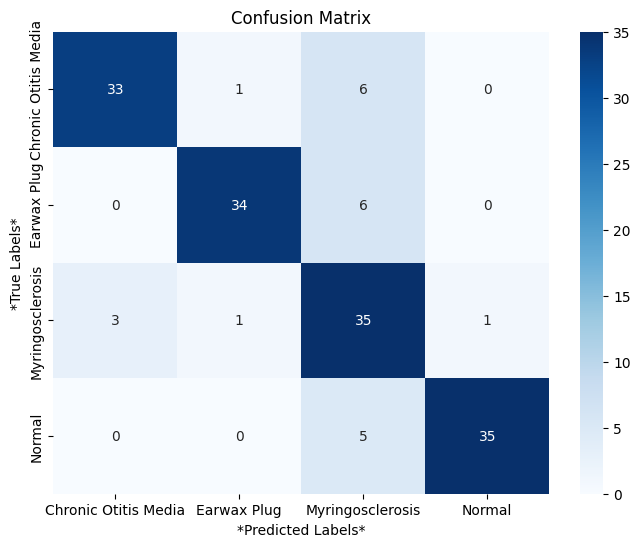

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract confusion matrix and class names
conf_matrix = metrics["confusion_matrix"]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("*Predicted Labels*")
plt.ylabel("*True Labels*")
plt.title("Confusion Matrix")
plt.show()


## Discussion:

Please, Pause for a moment and ponder.. The model showed a great accuracy. Can we deploy it now? Please check the dataset once (you may download it and see).

This is the end of the first part of this notebook.

# Part B: Fixing the Data Leakage and Retraining

The model earlier seems to be generalizing with such a great accuracy. But once again lets examine the data.

In [ ]:
import pandas as pd
import os
import shutil
from sklearn.model_selection import train_test_split

* The boring work of annotating the images has been done for you.
* **Find the csv file called 'Image_names_and_labels_datos.csv' at**:

https://drive.google.com/drive/folders/1p8D7qlyHHtq6QfJHyBD6QB8YSqmPuu_c?fbclid=IwAR1nOLKOcUspFEsgLekYPDDrkYrCksOX6rK1hhLPxGfVXFmom5uFLhK728g

You may do the following steps:
1. Download the file 'Image_names_and_labels_datos.csv'.
2. Upload to your drive
3. Use the path to the file (at your drive) in the following cells.

In [ ]:
csv_path = "/content/drive/MyDrive/extra/Image_names_and_labels_datos.csv"  # Path to the CSV file
dataset_dir = "/content/datos_dataset/Datos/Training-validation"  # Path to the dataset directory
output_dir = "/content/new_datos"  # Desired output directory

In [ ]:
data = pd.read_csv(csv_path)

In [ ]:
data

,Images,Labels,Person
0,n1.jpg,Normal,P1
1,n2.jpg,Normal,P1
2,n3.jpg,Normal,P1
3,n4.jpg,Normal,P1
4,n5.jpg,Normal,P1
...,...,...,...
715,o176.jpg,Chronic otitis media,P36
716,o177.jpg,Chronic otitis media,P36
717,o178.jpg,Chronic otitis media,P36
718,o179.jpg,Chronic otitis media,P36


It is evident that there exists multiple images of the same person. This has caused data leakage. That was the reason for such a high accuracy.Now to prevent so, lets split the dataset so that the same person's images won't leak from the training set to the testing set. That is, we want the same person's images to either be in training set or testing set, but not on both.

## Creating new Dataset:

In [ ]:
# Create directories for the new splits
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

Now check to see if the new directory has been made, with 2 internal directories called "test" and "train"

In [ ]:
print("Files/Directory inside the new_datos:")
print(os.listdir('/content/new_datos'))

Files/Directory inside the new_datos:
['test', 'train']


In [ ]:
grouped_data = data.groupby(["Labels", "Person"])

In [ ]:
grouped_data.head()

,Images,Labels,Person
0,n1.jpg,Normal,P1
1,n2.jpg,Normal,P1
2,n3.jpg,Normal,P1
3,n4.jpg,Normal,P1
4,n5.jpg,Normal,P1
...,...,...,...
715,o176.jpg,Chronic otitis media,P36
716,o177.jpg,Chronic otitis media,P36
717,o178.jpg,Chronic otitis media,P36
718,o179.jpg,Chronic otitis media,P36


Lets assign entire group to either train or test.

If the current ratio (train:all) is less than 0.8, put that whole group in train_set.
If the current ratio (train:all) is more than 0.8, put that whole group in test_set.

In [ ]:
# Initialize lists for train and test splits
train_images = []
test_images = []

# Randomly assign each group to train or test
for _, group in grouped_data:                                      # iterate over each "person" group within the "grouped_data"
    if len(group) > 0:
        # Randomly decide if the whole group goes to train or test
        if len(train_images) / (len(train_images) + len(test_images) + 1e-8) < 0.8:
            train_images.extend(group["Images"].tolist())
        else:
            test_images.extend(group["Images"].tolist())

In [ ]:
train_images

['o1.jpg',
 'o2.jpg',
 'o3.jpg',
 'o47.jpg',
 'o48.jpg',
 'o49.jpg',
 'o51.jpg',
 'o52.jpg',
 'o53.jpg',
 'o50.jpg',
 'o54.jpg',
 'o55.jpg',
 'o56.jpg',
 'o57.jpg',
 'o58.jpg',
 'o59.jpg',
 'o60.jpg',
 'o61.jpg',
 'o62.jpg',
 'o63.jpg',
 'o64.jpg',
 'o65.jpg',
 'o66.jpg',
 'o67.jpg',
 'o75.jpg',
 'o76.jpg',
 'o77.jpg',
 'o78.jpg',
 'o79.jpg',
 'o80.jpg',
 'o81.jpg',
 'o82.jpg',
 'o83.jpg',
 'o84.jpg',
 'o85.jpg',
 'o86.jpg',
 'o87.jpg',
 'o88.jpg',
 'o89.jpg',
 'o90.jpg',
 'o91.jpg',
 'o92.jpg',
 'o93.jpg',
 'o94.jpg',
 'o95.jpg',
 'o96.jpg',
 'o97.jpg',
 'o98.jpg',
 'o99.jpg',
 'o100.jpg',
 'o101.jpg',
 'o102.jpg',
 'o103.jpg',
 'o104.jpg',
 'o111.jpg',
 'o112.jpg',
 'o113.jpg',
 'o114.jpg',
 'o115.jpg',
 'o116.jpg',
 'o117.jpg',
 'o118.jpg',
 'o121.jpg',
 'o119.jpg',
 'o120.jpg',
 'o122.jpg',
 'o123.jpg',
 'o124.jpg',
 'o125.jpg',
 'o126.jpg',
 'o127.jpg',
 'o128.jpg',
 'o129.jpg',
 'o130.jpg',
 'o131.jpg',
 'o132.jpg',
 'o133.jpg',
 'o134.jpg',
 'o135.jpg',
 'o136.jpg',
 'o137.jpg',

In [ ]:
print(f"Training images: {len(train_images)}")
print(f"Testing images: {len(test_images)}")

Training images: 576
Testing images: 144


In [ ]:
dataset_dir, train_dir, test_dir

('/content/datos_dataset/Datos/Training-validation',
 '/content/new_datos/train',
 '/content/new_datos/test')

In [ ]:
## Only Use this to remove the existing directory

# new_datos_dir = "/content/new_datos"

# # Remove all contents from the directory
# if os.path.exists(new_datos_dir):
#     shutil.rmtree(new_datos_dir)

In [ ]:
def copy_images_with_hierarchy(image_list, dest_dir, dataset_dir, data_df):
    """
    Copies images from class-specific subfolders in `dataset_dir` to corresponding
    subfolders in `dest_dir`, preserving the subfolder hierarchy.

    Args:
        image_list (list): List of image file names to copy.
        dest_dir (str): Target directory to copy images into.
        dataset_dir (str): Source directory containing class subfolders.
        data_df (pd.DataFrame): Dataframe containing 'Labels' and 'Images'.
    """
    for image_name in image_list:
        # Find the label (subfolder) for the image from the dataframe
        label = data_df.loc[data_df["Images"] == image_name, "Labels"].values[0]

        # Construct the source and destination paths
        src_path = os.path.join(dataset_dir, label, image_name)
        dest_path = os.path.join(dest_dir, label, image_name)  # Include the label in dest_path

        # Ensure destination subfolder exists
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)

        # Check and copy the file
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)
            print(f"Copied: {src_path} -> {dest_path}")
        else:
            print(f"Warning: File not found: {src_path}")


In [ ]:
copy_images_with_hierarchy(train_images, train_dir, dataset_dir, data)

Copied: /content/datos_dataset/Datos/Training-validation/Chronic otitis media/o1.jpg -> /content/new_datos/train/Chronic otitis media/o1.jpg
Copied: /content/datos_dataset/Datos/Training-validation/Chronic otitis media/o2.jpg -> /content/new_datos/train/Chronic otitis media/o2.jpg
Copied: /content/datos_dataset/Datos/Training-validation/Chronic otitis media/o3.jpg -> /content/new_datos/train/Chronic otitis media/o3.jpg
Copied: /content/datos_dataset/Datos/Training-validation/Chronic otitis media/o47.jpg -> /content/new_datos/train/Chronic otitis media/o47.jpg
Copied: /content/datos_dataset/Datos/Training-validation/Chronic otitis media/o48.jpg -> /content/new_datos/train/Chronic otitis media/o48.jpg
Copied: /content/datos_dataset/Datos/Training-validation/Chronic otitis media/o49.jpg -> /content/new_datos/train/Chronic otitis media/o49.jpg
Copied: /content/datos_dataset/Datos/Training-validation/Chronic otitis media/o51.jpg -> /content/new_datos/train/Chronic otitis media/o51.jpg
Copie

New training set has been made with the same hierarchy of 4 clases.
Lets do the same for the training set.

In [ ]:
copy_images_with_hierarchy(test_images, test_dir, dataset_dir, data)

Copied: /content/datos_dataset/Datos/Training-validation/Chronic otitis media/o42.jpg -> /content/new_datos/test/Chronic otitis media/o42.jpg
Copied: /content/datos_dataset/Datos/Training-validation/Chronic otitis media/o43.jpg -> /content/new_datos/test/Chronic otitis media/o43.jpg
Copied: /content/datos_dataset/Datos/Training-validation/Chronic otitis media/o44.jpg -> /content/new_datos/test/Chronic otitis media/o44.jpg
Copied: /content/datos_dataset/Datos/Training-validation/Chronic otitis media/o45.jpg -> /content/new_datos/test/Chronic otitis media/o45.jpg
Copied: /content/datos_dataset/Datos/Training-validation/Chronic otitis media/o46.jpg -> /content/new_datos/test/Chronic otitis media/o46.jpg
Copied: /content/datos_dataset/Datos/Training-validation/Chronic otitis media/o68.jpg -> /content/new_datos/test/Chronic otitis media/o68.jpg
Copied: /content/datos_dataset/Datos/Training-validation/Chronic otitis media/o69.jpg -> /content/new_datos/test/Chronic otitis media/o69.jpg
Copied

### Dataloaders:

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
# Paths to the train and test directories
new_train_dir = "/content/new_datos/train"  # Replace with your train folder path
new_test_dir = "/content/new_datos/test"    # Replace with your test folder path

In [ ]:
new_train_dataset = EardrumDataset(new_train_dir, transform = transform)
new_test_dataset = EardrumDataset(new_test_dir, transform = transform)

Split the above new_train_dataset further into train and validation (ratio 0.85:0.15).

Note that this splitting is done randomly. (This information will come handy later)

In [ ]:
new_train_dataset, new_val_dataset = random_split(new_train_dataset, [0.85, 0.15], generator = torch.Generator().manual_seed(42))

In [ ]:
len(new_train_dataset), len(new_val_dataset), len(new_test_dataset)

(490, 86, 144)

In [ ]:
new_train_loader = DataLoader(new_train_dataset, batch_size=8, shuffle = True)
new_val_loader = DataLoader(new_val_dataset, batch_size=8, shuffle = False)
new_test_loader = DataLoader(new_test_dataset, batch_size=8, shuffle = False)

In [ ]:
len(new_train_loader), len(new_val_loader), len(new_test_loader)

(62, 11, 18)

In [ ]:
for images, labels in new_train_loader:
    print(f"Batch size: {images.size(0)}")
    print(f"Image shape: {images.shape}")
    print(f"Labels: {labels}")
    break

Batch size: 8
Image shape: torch.Size([8, 3, 224, 224])
Labels: tensor([3, 1, 3, 2, 1, 3, 0, 0])


## Model training

We had instantiated our resnet50 model earlier

In [ ]:
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
import torch.optim as optim
from tqdm import tqdm

In [ ]:
import os

def train_model(model, train_loader, val_loader, num_epochs, device, save_path):
    # Mount Google Drive (if necessary)
    from google.colab import drive
    drive.mount('/content/drive')

    # Criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.to(device)

    # Initialize logs
    logs = {
        "train_loss": [],
        "val_loss": [],
        "train_accuracy": [],
        "val_accuracy": []
    }
    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_accuracy = correct / total * 100
        logs["train_loss"].append(train_loss)
        logs["train_accuracy"].append(train_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_accuracy = val_correct / val_total * 100
        logs["val_loss"].append(val_loss)
        logs["val_accuracy"].append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), os.path.join(save_path, "best_model.pth"))
            print(f"Best model saved with Validation Accuracy: {val_accuracy:.2f}%")

        # Save model every 10 epochs
        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), os.path.join(save_path, f"model_epoch_{epoch+1}.pth"))
            print(f"Model saved at epoch {epoch+1}")

    # Save logs for plotting
    torch.save(logs, os.path.join(save_path, "training_logs.pth"))
    print("Training completed and logs saved.")


In [ ]:
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
save_path = '/content/drive/MyDrive/naamii/workshop/new_datos'

In [ ]:
train_model(resnet_model, new_train_loader, new_val_loader, num_epochs=20, device=device, save_path=save_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Epoch 1/20 - Training: 100%|██████████| 62/62 [06:17<00:00,  6.09s/it]


Epoch 1/20, Train Loss: 1.2854, Train Accuracy: 54.90%


Epoch 1/20 - Validation: 100%|██████████| 11/11 [00:18<00:00,  1.69s/it]


Epoch 1/20, Val Loss: 1.1971, Val Accuracy: 60.47%
Best model saved with Validation Accuracy: 60.47%


Epoch 2/20 - Training: 100%|██████████| 62/62 [06:14<00:00,  6.04s/it]


Epoch 2/20, Train Loss: 0.8277, Train Accuracy: 66.33%


Epoch 2/20 - Validation: 100%|██████████| 11/11 [00:18<00:00,  1.70s/it]


Epoch 2/20, Val Loss: 14.4055, Val Accuracy: 41.86%


Epoch 3/20 - Training: 100%|██████████| 62/62 [06:13<00:00,  6.03s/it]


Epoch 3/20, Train Loss: 0.9041, Train Accuracy: 67.14%


Epoch 3/20 - Validation: 100%|██████████| 11/11 [00:18<00:00,  1.70s/it]


Epoch 3/20, Val Loss: 0.5596, Val Accuracy: 74.42%
Best model saved with Validation Accuracy: 74.42%


Epoch 4/20 - Training: 100%|██████████| 62/62 [06:14<00:00,  6.04s/it]


Epoch 4/20, Train Loss: 0.6022, Train Accuracy: 75.71%


Epoch 4/20 - Validation: 100%|██████████| 11/11 [00:18<00:00,  1.69s/it]


Epoch 4/20, Val Loss: 0.7349, Val Accuracy: 72.09%


Epoch 5/20 - Training: 100%|██████████| 62/62 [06:10<00:00,  5.97s/it]


Epoch 5/20, Train Loss: 0.5292, Train Accuracy: 81.84%


Epoch 5/20 - Validation: 100%|██████████| 11/11 [00:19<00:00,  1.74s/it]


Epoch 5/20, Val Loss: 0.2561, Val Accuracy: 93.02%
Best model saved with Validation Accuracy: 93.02%


Epoch 6/20 - Training: 100%|██████████| 62/62 [06:14<00:00,  6.03s/it]


Epoch 6/20, Train Loss: 0.4870, Train Accuracy: 82.04%


Epoch 6/20 - Validation: 100%|██████████| 11/11 [00:18<00:00,  1.70s/it]


Epoch 6/20, Val Loss: 1.2517, Val Accuracy: 60.47%


Epoch 7/20 - Training: 100%|██████████| 62/62 [06:11<00:00,  5.99s/it]


Epoch 7/20, Train Loss: 0.5352, Train Accuracy: 80.41%


Epoch 7/20 - Validation: 100%|██████████| 11/11 [00:19<00:00,  1.81s/it]


Epoch 7/20, Val Loss: 0.2409, Val Accuracy: 93.02%


Epoch 8/20 - Training: 100%|██████████| 62/62 [06:11<00:00,  5.99s/it]


Epoch 8/20, Train Loss: 0.4453, Train Accuracy: 84.90%


Epoch 8/20 - Validation: 100%|██████████| 11/11 [00:19<00:00,  1.78s/it]


Epoch 8/20, Val Loss: 0.2333, Val Accuracy: 94.19%
Best model saved with Validation Accuracy: 94.19%


Epoch 9/20 - Training: 100%|██████████| 62/62 [06:06<00:00,  5.92s/it]


Epoch 9/20, Train Loss: 0.3876, Train Accuracy: 86.33%


Epoch 9/20 - Validation: 100%|██████████| 11/11 [00:19<00:00,  1.79s/it]


Epoch 9/20, Val Loss: 0.6254, Val Accuracy: 76.74%


Epoch 10/20 - Training: 100%|██████████| 62/62 [06:13<00:00,  6.03s/it]


Epoch 10/20, Train Loss: 0.3161, Train Accuracy: 91.02%


Epoch 10/20 - Validation: 100%|██████████| 11/11 [00:19<00:00,  1.80s/it]


Epoch 10/20, Val Loss: 0.1526, Val Accuracy: 96.51%
Best model saved with Validation Accuracy: 96.51%
Model saved at epoch 10


Epoch 11/20 - Training: 100%|██████████| 62/62 [06:15<00:00,  6.06s/it]


Epoch 11/20, Train Loss: 0.4193, Train Accuracy: 86.73%


Epoch 11/20 - Validation: 100%|██████████| 11/11 [00:18<00:00,  1.68s/it]


Epoch 11/20, Val Loss: 0.4488, Val Accuracy: 82.56%


Epoch 12/20 - Training: 100%|██████████| 62/62 [06:08<00:00,  5.95s/it]


Epoch 12/20, Train Loss: 0.3733, Train Accuracy: 86.12%


Epoch 12/20 - Validation: 100%|██████████| 11/11 [00:18<00:00,  1.66s/it]


Epoch 12/20, Val Loss: 0.9690, Val Accuracy: 70.93%


Epoch 13/20 - Training: 100%|██████████| 62/62 [06:07<00:00,  5.93s/it]


Epoch 13/20, Train Loss: 0.2898, Train Accuracy: 89.59%


Epoch 13/20 - Validation: 100%|██████████| 11/11 [00:19<00:00,  1.74s/it]


Epoch 13/20, Val Loss: 0.0834, Val Accuracy: 97.67%
Best model saved with Validation Accuracy: 97.67%


Epoch 14/20 - Training: 100%|██████████| 62/62 [06:07<00:00,  5.93s/it]


Epoch 14/20, Train Loss: 0.2804, Train Accuracy: 90.41%


Epoch 14/20 - Validation: 100%|██████████| 11/11 [00:18<00:00,  1.68s/it]


Epoch 14/20, Val Loss: 0.9606, Val Accuracy: 70.93%


Epoch 15/20 - Training: 100%|██████████| 62/62 [06:10<00:00,  5.98s/it]


Epoch 15/20, Train Loss: 0.2459, Train Accuracy: 92.24%


Epoch 15/20 - Validation: 100%|██████████| 11/11 [00:18<00:00,  1.70s/it]


Epoch 15/20, Val Loss: 0.3945, Val Accuracy: 82.56%


Epoch 16/20 - Training: 100%|██████████| 62/62 [06:08<00:00,  5.94s/it]


Epoch 16/20, Train Loss: 0.3961, Train Accuracy: 86.12%


Epoch 16/20 - Validation: 100%|██████████| 11/11 [00:20<00:00,  1.83s/it]


Epoch 16/20, Val Loss: 0.5530, Val Accuracy: 87.21%


Epoch 17/20 - Training: 100%|██████████| 62/62 [06:10<00:00,  5.97s/it]


Epoch 17/20, Train Loss: 0.2926, Train Accuracy: 89.59%


Epoch 17/20 - Validation: 100%|██████████| 11/11 [00:19<00:00,  1.75s/it]


Epoch 17/20, Val Loss: 0.7843, Val Accuracy: 74.42%


Epoch 18/20 - Training: 100%|██████████| 62/62 [06:06<00:00,  5.91s/it]


Epoch 18/20, Train Loss: 0.3331, Train Accuracy: 89.59%


Epoch 18/20 - Validation: 100%|██████████| 11/11 [00:22<00:00,  2.08s/it]


Epoch 18/20, Val Loss: 0.3157, Val Accuracy: 84.88%


Epoch 19/20 - Training: 100%|██████████| 62/62 [06:06<00:00,  5.91s/it]


Epoch 19/20, Train Loss: 0.1503, Train Accuracy: 94.90%


Epoch 19/20 - Validation: 100%|██████████| 11/11 [00:18<00:00,  1.69s/it]


Epoch 19/20, Val Loss: 0.0959, Val Accuracy: 96.51%


Epoch 20/20 - Training: 100%|██████████| 62/62 [06:07<00:00,  5.93s/it]


Epoch 20/20, Train Loss: 0.2726, Train Accuracy: 89.80%


Epoch 20/20 - Validation: 100%|██████████| 11/11 [00:20<00:00,  1.86s/it]


Epoch 20/20, Val Loss: 0.1905, Val Accuracy: 96.51%
Model saved at epoch 20
Training completed and logs saved.


Plot the training details:

In [ ]:
import matplotlib.pyplot as plt

def plot_training_logs(logs_path):
    # Load logs
    logs = torch.load(logs_path)

    train_loss = logs["train_loss"]
    val_loss = logs["val_loss"]
    train_accuracy = logs["train_accuracy"]
    val_accuracy = logs["val_accuracy"]

    # Plot Loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label="Training Loss", color="blue")
    plt.plot(val_loss, label="Validation Loss", color="orange")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracy, label="Training Accuracy", color="green")
    plt.plot(val_accuracy, label="Validation Accuracy", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

* **Alterntaively**, Find the training logs file at:

https://drive.google.com/drive/folders/1p8D7qlyHHtq6QfJHyBD6QB8YSqmPuu_c?fbclid=IwAR1nOLKOcUspFEsgLekYPDDrkYrCksOX6rK1hhLPxGfVXFmom5uFLhK728g


<ipython-input-67-32f49ee18464>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  logs = torch.load(logs_path)


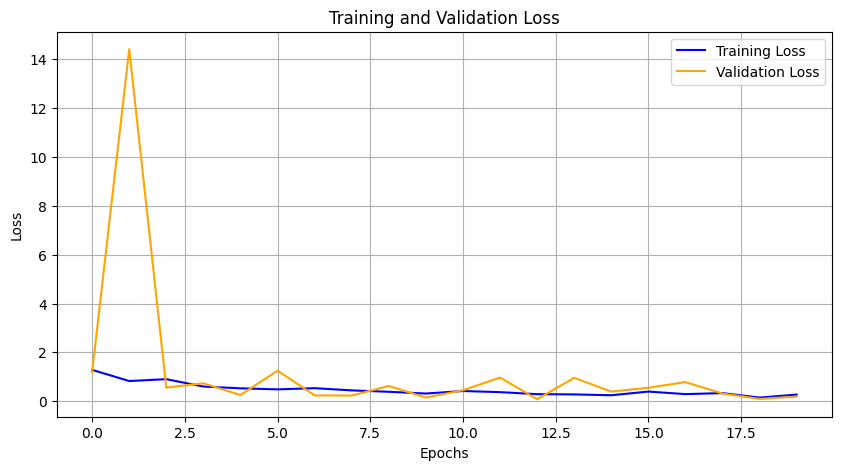

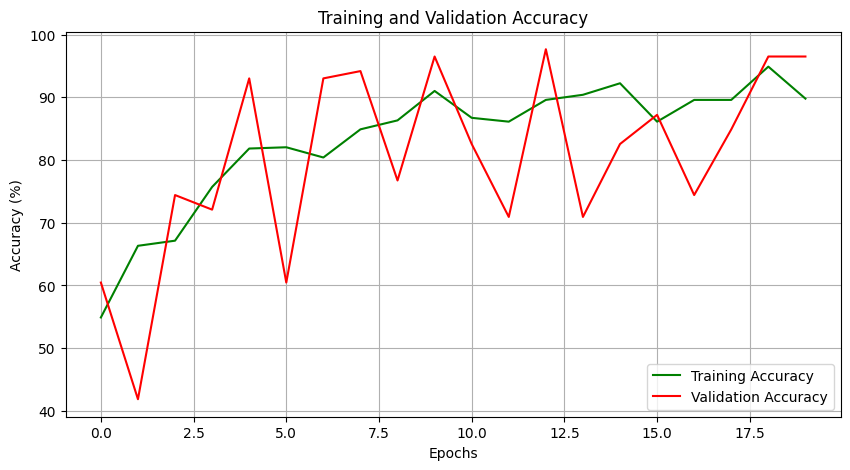

In [ ]:
logs_path = "/content/drive/MyDrive/naamii/workshop/new_datos/training_logs.pth"  # Update the path to match your logs
plot_training_logs(logs_path)

The model seems to be performing well on validation set because validation set still contains the data leaked from the training set. This is because we randomly splitted the train-val set into training and validation set.

## Evaluation:

Now let's evaluate on the test set. Note that this test set contains different images, since we fixed the data leakage problem earlier while splitting.

The expected accuracy on this new test set is pretty low since there is no leakage now. This means earlier our model had shown high accuracy on previous test set because of the data leakage, thereby the model seemed to be performing well even though it was clearly not.

In [ ]:
def test_model(model, test_loader, device, model_path):
    # Load the best model
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    criterion = nn.CrossEntropyLoss()

    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Accumulate loss
            test_loss += loss.item() * images.size(0)

            # Compute accuracy
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_loss /= total
    test_accuracy = correct / total * 100

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    return test_loss, test_accuracy

* **Alternatively**, find the trained model (.pth) file at:

https://drive.google.com/drive/folders/1p8D7qlyHHtq6QfJHyBD6QB8YSqmPuu_c?fbclid=IwAR1nOLKOcUspFEsgLekYPDDrkYrCksOX6rK1hhLPxGfVXFmom5uFLhK728g


In [ ]:
model_path = "/content/drive/MyDrive/naamii/workshop/new_datos/model_epoch_20.pth"  # Path to the saved best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
new_test_loss, new_test_accuracy = test_model(resnet_model, new_test_loader, device, model_path)

<ipython-input-61-629285c95b09>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
Testing: 100%|██████████| 18/18 [00:28<00:00, 

Test Loss: 1.0857
Test Accuracy: 70.83%


As expected!

Thus, even though the model might be performing well on validation set, it might not perform well on the test set. This claim is proven now that we have fixed the leakage problem.

Detailed metrics:

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [ ]:
def evaluate_model(model, test_loader, device, model_path, class_names):
    # Load the best model
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    criterion = nn.CrossEntropyLoss()

    # Initialize accumulators and metrics
    test_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Accumulate loss
            test_loss += loss.item() * images.size(0)

            # Store predictions and true labels
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to NumPy arrays for sklearn metrics
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate test loss
    test_loss /= len(test_loader.dataset)

    # Classification report
    class_report = classification_report(all_labels, all_preds, target_names=class_names, digits=4, output_dict=True)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Class-wise accuracy
    class_accuracy = {class_names[i]: conf_matrix[i, i] / conf_matrix[i].sum() for i in range(len(class_names))}

    # Print metrics
    print(f"Test Loss: {test_loss:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
    print("\nConfusion Matrix:")
    print(conf_matrix)

    # Prepare metrics dictionary
    metrics = {
        "test_loss": test_loss,
        "class_report": class_report,
        "confusion_matrix": conf_matrix,
        "class_accuracy": class_accuracy,
    }

    return metrics

same path

In [ ]:
model_path = "/content/drive/MyDrive/naamii/workshop/new_datos/model_epoch_20.pth"  # Path to the saved best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
class_names = ["Chronic Otitis Media", "Earwax Plug", "Myringosclerosis", "Normal"]

new_metrics = evaluate_model(resnet_model, new_test_loader, device, model_path, class_names)

<ipython-input-71-2176a71d715c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
Testing: 100%|██████████| 18/18 [00:32<00:00, 

Test Loss: 1.0857

Classification Report:
                      precision    recall  f1-score   support

Chronic Otitis Media     0.8095    0.7727    0.7907        44
         Earwax Plug     0.9032    0.7179    0.8000        39
    Myringosclerosis     0.4359    0.7727    0.5574        22
              Normal     0.7188    0.5897    0.6479        39

            accuracy                         0.7083       144
           macro avg     0.7168    0.7133    0.6990       144
        weighted avg     0.7532    0.7083    0.7189       144


Confusion Matrix:
[[34  3  0  7]
 [ 5 28  6  0]
 [ 3  0 17  2]
 [ 0  0 16 23]]


In [ ]:
print("\nClass-wise Accuracy:")
for class_name, accuracy in new_metrics["class_accuracy"].items():
    print(f"{class_name}: {accuracy:.2%}")


Class-wise Accuracy:
Chronic Otitis Media: 77.27%
Earwax Plug: 71.79%
Myringosclerosis: 77.27%
Normal: 58.97%


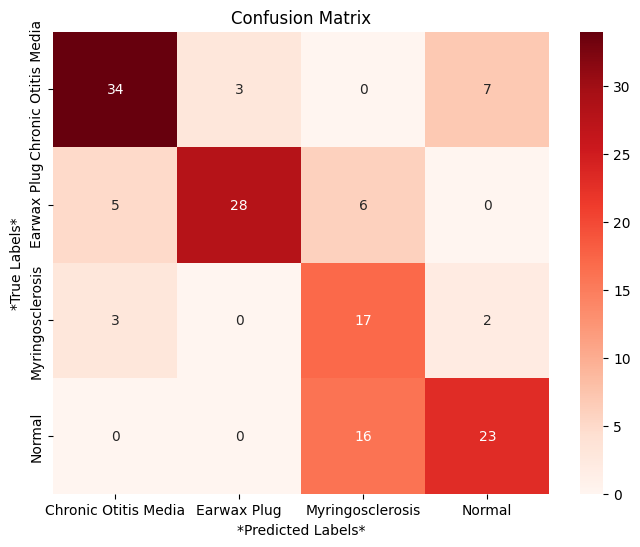

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract confusion matrix and class names
new_conf_matrix = new_metrics["confusion_matrix"]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(new_conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("*Predicted Labels*")
plt.ylabel("*True Labels*")
plt.title("Confusion Matrix")
plt.show()
